In [1]:
# See if K-fold cross_validation can help to get the model trained better.
# Graph the different degrees to get highly fit, but short of over-fitting.
#Use scientific wording to describe methodology.
#Concluding Remarks with prominent header.
#Show process.
#Explain what trying to predict.

Use zip code to determine borough in some cases?

Look up addresses with missing info in one data set with the address in the other data set?

Deal with unbalanced data set?

Make sure before dropping a row that it doesn't have valid data in any important rows.  If it is simply a mostly blank row, then drop it.

Some features contain hidden clues.  Such as description in the 311 database.  Some of them gave clues that some complaints were duplicates from the same address.

Know the difference between median and mean values.

Some missing features can be computed from other features.  Like floor area ratio from building area and lot size.

Watch for type features that cause other columns to be relevant or not.

What is category type?   .astype('category')  In Pandas DataFrame.  One peer changed all categorical variables to this.

RandomForestClassifier and RandomForestRegressor can be used to calculate feature importances.

#### <h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 4 of 4</p>

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 4
---

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## Approach
Attempt to build a predictive model to predict heating complaints by using past data.
Assemble complaint data vs. time.
Graph it to get a sense of any patterns.
Build model.
Test model 

Determine relationship between number of complaints over time.
Establish regression model to calculate number of complaints for each day of the year.



## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

In [71]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [3]:
# Only load the NY 311 data for this question.
df = pd.read_pickle(files_path + 'ny311full.pkl')
print("Shape of initial data %s" % (df.shape,))

Shape of initial data (5862383, 15)


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

### General

In [4]:
# Remove features deemed unnecessary for this question.
df.drop(['street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude','incident_zip','incident_address','city','borough'], axis=1, inplace=True)
print("Shape after first feature culling %s" % (df.shape,))

Shape after first feature culling (5862383, 2)


In [5]:
# Only use the combined "heating and hot water" type of observations determined from Question 1.
df['complaint_type'] = df['complaint_type'].str.upper()
df.drop(df[df["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
# The complaint type is only used for filtering observations this time.
df.drop(['complaint_type'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
print("Shape after row culling based on complaint type %s" % (df.shape,))

Shape after row culling based on complaint type (2040461, 1)


In [6]:
# Data types
df.dtypes

created_date    object
dtype: object

In [7]:
# Convert the date into actual datetime type.
df['created_date'] = pd.to_datetime(df['created_date'])
df.dtypes

created_date    datetime64[ns]
dtype: object

In [8]:
# Nulls
df.isnull().sum()

created_date    0
dtype: int64

In [9]:
# Check ranges
df.describe()

,created_date
count,2040461
unique,855540
top,2013-01-24 00:00:00
freq,5847
first,2010-01-01 00:00:00
last,2019-09-28 23:48:12


## Latent variables
Derived from the other data

### Break the created_date into latent variables for year and day of year.

In [10]:
# Break the created_date into latent variables for year and day of year.
df['Year'] = df['created_date'].dt.year
df['DayOfYear'] = df['created_date'].dt.dayofyear

### Structure the data into total complaints per day.

In [35]:
totals = df.groupby(['Year','DayOfYear']).size()
totals = pd.DataFrame(totals)
totals.reset_index(inplace=True)
totals.columns=['Year','DayOfYear','Complaints']
totals.head()

,Year,DayOfYear,Complaints
0,2010,1,770
1,2010,2,1457
2,2010,3,2785
3,2010,4,2740
4,2010,5,2036


In [36]:
# See ranges
min = df['Year'].min()
max = df['Year'].max()
print(min, max)

2010 2019


## Analyze including Visualizations

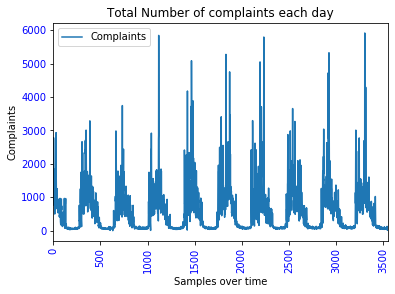

In [58]:
# Basic visualization
totals[['Complaints']].plot(title="Total Number of complaints each day")
plt.xticks(rotation=90,color='blue')
plt.yticks(color='blue')
plt.ylabel("Complaints")
plt.xlabel("Samples over time")
plt.show()

<p style="color:Red;"><b>Observation:</b>  There appears to be a general recurring U pattern each year.  Presumably heating complaints higher in the winter months.</p>

In [ ]:
# Given the curves, a linear regression seems unlikely, but try it anyway just to confirm.
lm=LinearRegression()
X = totals[['DayOfYear']]
Y = totals[['Complaints']]
lm.fit(X,Y)
Yhat=lm.predict(X)

3556
3556


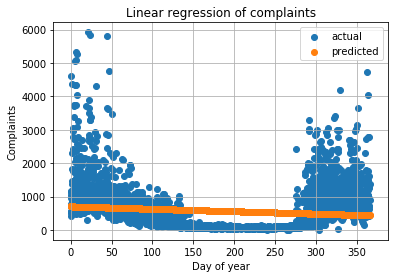

In [59]:
plt.title("Linear regression of complaints")
plt.scatter(X, Y, label="actual")
plt.scatter(X, Yhat, label="predicted")
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Complaints')
plt.grid()
plt.show()

In [ ]:
# As expected, a simple linear regression doesn't predict the complaints very well.

In [ ]:
# The parabolic U shape suggests a Non-Linear quadratic function.
# A degree two polynomial.
# ax^2 + bx + c = 0

In [116]:
# Function for trying out different degree polynomials.
def poly(degrees):
    Xtrain = totals[totals['Year'].lt(2018)][['DayOfYear']]
    Ytrain = totals[totals['Year'].lt(2018)][['Complaints']]
    Xtest = totals[totals['Year'].eq(2018)][['DayOfYear']]
    Ytest = totals[totals['Year'].eq(2018)][['Complaints']]
    Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=degrees, include_bias=False)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    pipe.fit(Xtrain,Ytrain)
    Y_hat_train =pipe.predict(Xtrain)
    Y_hat_test =pipe.predict(Xtest)
    plt.title("Polynomial (degree " + str(degrees) + ") regression of complaints")
    plt.scatter(Xtrain, Ytrain, label="actual train", marker ='|')
    plt.scatter(Xtrain, Y_hat_train, label="predicted train", marker ='|')
    plt.scatter(Xtest, Ytest, label="actual test", marker ='_')
    plt.scatter(Xtest, Y_hat_test, label="predicted test", marker ='_')
    plt.legend()
    plt.xlabel('Day of year')
    plt.ylabel('Complaints')
    plt.grid()
    plt.show()
    print('Train')
    print('  Mean squared error: ', mean_squared_error(Ytrain, Y_hat_train))
    print('  R-squared: ', r2_score(Ytrain, Y_hat_train))
    print('Test')
    print('  Mean squared error: ', mean_squared_error(Ytest, Y_hat_test))
    print('  R-squared: ', r2_score(Ytest, Y_hat_test))    

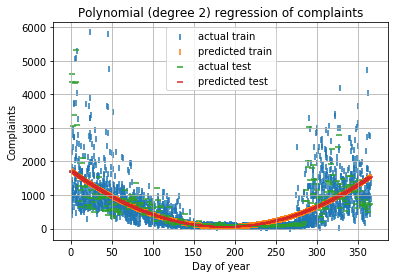

Train
  Mean squared error:  239448.3635704648
  R-squared:  0.4853279805904034
Test
  Mean squared error:  287937.6488689016
  R-squared:  0.47210757215916943


In [117]:
poly(2)

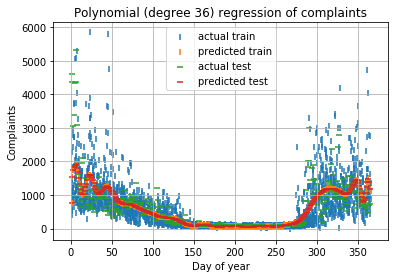

Train
  Mean squared error:  209019.10643868055
  R-squared:  0.5507328427645419
Test
  Mean squared error:  277045.3125747256
  R-squared:  0.492077110265002


In [131]:
poly(36)

### Alternative approaches

<p style="color:Red;">A few attempts to build a model to see whether the correlations seen with Pearson Correlation above seem correct.</p>

<a id="conclusion"></a>
# Concluding Remarks
---

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

<b><u>Yes</u>, the HEATING/HOT WATER complaints (question 1) reported in the BRONX borough (question 2) have an obvious relationship with the housing characteristics.</b>  Some weak but distinct correlations:
<ul>
    <li><b><u>Building Type</u></b>.  Certain types are more or less prone to heating complaints than others:
    <ul>
        <li>Apartments!  <i>(Correlation:  0.43)</i>
        <ul>
            <li>Walk up apartments.  These are the most likely to have complaints.   <i>(Correlation:  0.34)</i>
            <li>Elevator apartments.  These are the second most likely to have complaints. <i>(Correlation:  0.26)</i>
        </ul>
        <li>One and two family homes.  These are <u>less</u> likely to have heating complaints than other building types.  <i>(Correlation:  -0.34 <u>negative</u>)</i>
    </ul>
    <li><b><u>Size</u></b>.  The larger the building, the more heating complaints.
    <ul>
        <li>Number of Floors.  <i>(Correlation:  0.27~0.37)</i>
        <li>Floor Area.  <i>(Correlation:  0.23~0.35)</i>
        <li>Building Depth.  <i>(Correlation:  0.17~0.26)</i>
    </ul>
</ul>
<u><b>Additional insights</b></u>:
<ul>
    <li>When there are complaints at elevator apartments it is much more likely there will be a <u>large number of complaints per address</u> with <i>0.28 correlation</i> compared to <i>only 0.07</i> for the walk up apartments.
    <li>The land use category 1 encompasses both single and two family homes.  Breaking them down by building class A and B, shows that single family homes contribute much more to the negative correlation to complaints <i>(-0.27)</i> than two family homes. <i>(-0.09)</i>
</ul>